**Churn Prediction for a Telecom Company**

Install libraries

In [1]:
!pip install xgboost imbalanced-learn shap

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
    --------------------------------------- 3.7/150.0 MB 24.3 MB/s eta 0:00:07
   -- ------------------------------------- 10.0/150.0 MB 27.0 MB/s eta 0:00:06
   ---- ----------------------------------- 15.7/150.0 MB 27.5 MB/s eta 0:00:05
   ----- ---------------------------------- 21.5/150.0 MB 27.8 MB/s eta 0:00:05
   ------- -------------------------------- 27.5/150.0 MB 27.7 MB/s eta 0:00:05
   --------- ------------------------------ 34.6/150.0 MB 28.5 MB/s eta 0:00:05
   ----------- ---------------------------- 42.5/150.0 MB 29.7 MB/s eta 0:00:04
   ------------- -------------------------- 49.0/150.0 MB 29.7 MB/s eta 0:00:04
   --------------- ------------------------ 56.6/150.0 MB 30.3 MB/s eta 0:00:04
   ---------------- ----------------------- 63.7/150.0 MB 30.8 MB/s eta 0:00:03
   ------------------- -------------------- 71.3/150.0 MB 31.1 MB/s eta 0:00:03
   --------------------- ------------------ 79.4/1

Import required packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)

from imblearn.over_sampling import SMOTE
import shap


Matplotlib is building the font cache; this may take a moment.


Load dataset

In [9]:
# Load the dataset
df = pd.read_csv("C:\\Users\\anufn\\Downloads\\WA_Fn-UseC_-Telco-Customer-Churn.csv")

# View the first few rows
print(df.head())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [10]:
# Shape of the data (rows, columns)
print("Shape:", df.shape)

# Data types and null values
print(df.info())


Shape: (7043, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 n

Data preprocessing

In [11]:
df.drop('customerID', axis=1, inplace=True)

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

df['Churn'] = df['Churn'].map({'No':0, 'Yes':1})

cat_cols = df.select_dtypes(include='object').columns
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)
df.head()

C:\Users\anufn\AppData\Local\Temp\ipykernel_22584\4158013211.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,False,True,False,False,True,...,False,False,False,False,False,False,True,False,True,False
1,0,34,56.95,1889.50,0,True,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
2,0,2,53.85,108.15,1,True,False,False,True,False,...,False,False,False,False,False,False,True,False,False,True
3,0,45,42.30,1840.75,0,True,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
4,0,2,70.70,151.65,1,False,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False


Split and scale features

In [12]:
X = df.drop('Churn', axis=1)
y = df['Churn']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

Handle imbalance with SMOTE

In [13]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE:", np.bincount(y_train_bal))

Before SMOTE: [4139 1495]
After SMOTE: [4139 4139]


Define and train models

In [14]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train_bal, y_train_bal)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f"===== {name} =====")
    print(f"Accuracy: {acc:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\n")

    results[name] = {'model': model, 'accuracy': acc, 'roc_auc': roc_auc, 'y_proba': y_proba}


===== Logistic Regression =====
Accuracy: 0.7388
ROC AUC: 0.8404
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.72      0.80      1035
           1       0.51      0.80      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.75      1409

Confusion Matrix:
 [[742 293]
 [ 75 299]]


===== Random Forest =====
Accuracy: 0.7771
ROC AUC: 0.8233
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.84      0.85      1035
           1       0.58      0.60      0.59       374

    accuracy                           0.78      1409
   macro avg       0.72      0.72      0.72      1409
weighted avg       0.78      0.78      0.78      1409

Confusion Matrix:
 [[872 163]
 [151 223]]




C:\Users\anufn\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:43:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


===== XGBoost =====
Accuracy: 0.7679
ROC AUC: 0.8178
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.83      0.84      1035
           1       0.56      0.60      0.58       374

    accuracy                           0.77      1409
   macro avg       0.70      0.71      0.71      1409
weighted avg       0.77      0.77      0.77      1409

Confusion Matrix:
 [[859 176]
 [151 223]]




Plot ROC curve comparison

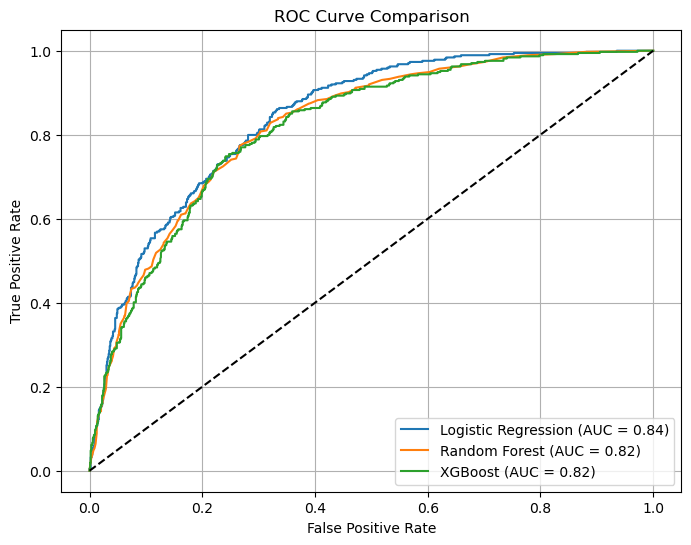

In [15]:
plt.figure(figsize=(8,6))

for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res['y_proba'])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {res['roc_auc']:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid()
plt.show()

SHAP explainability for best model

SHAP summary plot for best model: Logistic Regression


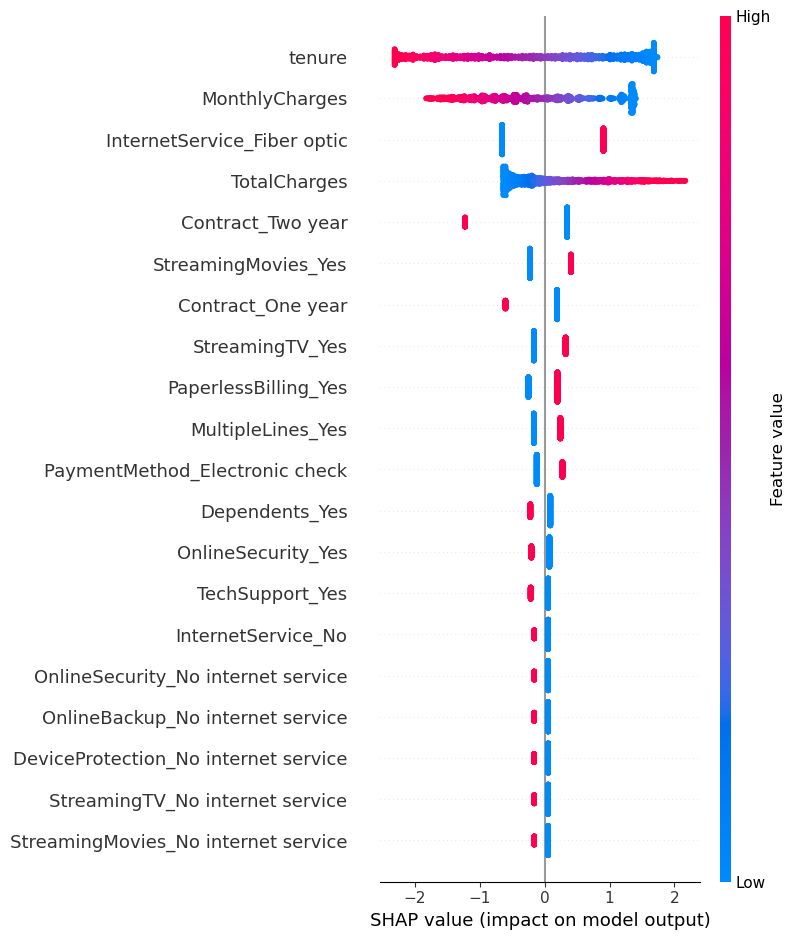

In [16]:
best_model_name = max(results, key=lambda k: results[k]['roc_auc'])
best_model = results[best_model_name]['model']

explainer = shap.Explainer(best_model, X_test)
shap_values = explainer(X_test)

print(f"SHAP summary plot for best model: {best_model_name}")
shap.summary_plot(shap_values, X_test, feature_names=X.columns)
